In [107]:
import cv2
import scipy
import imageio.v3 as iio
import os
import imagehash
from imagehash import ImageHash
from PIL import Image
import numpy as np
import skimage.io as io
import json
from loguru import logger

In [108]:
CACHE_DIR = r'C:\Users\Jonathan\.mkv-episode-matcher\cache'
def hashes_are_similar(hash1, hash2, threshold=20):
    """
    Determine if two perceptual hashes are similar within a given threshold.
    
    Args:
    - hash1: The first perceptual hash to compare.
    - hash2: The second perceptual hash to compare.
    - threshold: The maximum allowed difference between the hashes for them to be considered similar.
    
    Returns:
    - A tuple containing two values:
        - A boolean value indicating whether the hashes are similar within the threshold.
        - The hamming distance between the hashes.
    """
    hamming_distance = abs(hash1 - hash2)
    return hamming_distance <= threshold, hamming_distance
def load_show_hashes(show_name,hash_type):
    """
    Load the hashes for a given show from a JSON file.

    Args:
        show_name (str): The name of the show.

    Returns:
        dict: A dictionary containing the loaded hashes, or an empty dictionary if the JSON file doesn't exist.
    """
    json_file_path = os.path.join(CACHE_DIR, f"{show_name}_hashes_{hash_type}.json")
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as json_file:
            return json.load(json_file)
    else:
        return {}

def store_show_hashes(show_name, show_hashes,hash_type):
    """
    Stores the hashes of a show in a JSON file.

    Args:
        show_name (str): The name of the show.
        show_hashes (dict): A dictionary containing the hashes of the show.

    Returns:
        None
    """
    json_file_path = os.path.join(CACHE_DIR, f"{show_name}_hashes_{hash_type}.json")
    with open(json_file_path, 'w') as json_file:
        json.dump(show_hashes, json_file, default=lambda x: x.result() if isinstance(x, ThreadPoolExecutor) else x)
    logger.info(f"Show hashes saved to {json_file_path}")
def preprocess_hashes(show_name, show_id, seasons_to_process,hash_type):
    """
    Preprocess hashes by loading them from the file or fetching and hashing them if necessary.

    Args:
        show_name (str): The name of the show.
        show_id (str): The TMDb ID of the show.
        seasons_to_process (list): A list of season numbers to process.

    Returns:
        dict: A dictionary containing the hashes for each season.
    """
    for season_number in seasons_to_process:
        existing_hashes = load_show_hashes(show_name,hash_type)

    # Convert hash values from strings back to appropriate type (e.g., integers)
    for season, episodes in existing_hashes.items():
        for episode_number, episode_hashes in episodes.items():
            existing_hashes[season][episode_number] = [imagehash.hex_to_hash(hash_str) for hash_str in episode_hashes]
    return existing_hashes

In [109]:
# from tqdm import tqdm
# mkv_file = r'E:\Star Trek - The Next Generation\Season 1\Star Trek - The Next Generation - 000.mkv'
# metadata = iio.immeta(mkv_file)
# total_frames = int(metadata['fps'] * metadata['duration'])
# filename = os.path.basename(mkv_file)
# # calculated average and phash hashes for each frame and store them in a dictionary
# # average_hashes = {}
# # p_hashes = {}
# total_iterations = total_frames // 100
# # def calculate_hashes(frame_count):
# #     try:
# #         frame = iio.imread(mkv_file, index=frame_count, plugin="pyav")
# #         image = io.imread(frame)
# #         # hash = calculate_image_hash(frame, False)
# #         return frame_count, hash
# #     except Exception as e:
# #         print(f"Error in worker process: {e}")
# #         raise

# # for idx in tqdm(range(0, total_iterations, 10)):
# #     frame = iio.imread(mkv_file, index=idx, plugin="pyav")
# #     # image = io.imread(frame)

# # # hashes = {i: avg for i, avg in processed_images}


In [110]:
def average_hash(image, hash_size=8, mean=np.mean):
    if hash_size < 2:
        raise ValueError('Hash size must be greater than or equal to 2')

    # Convert the image to grayscale and resize it
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    resized_image = cv2.resize(gray_image, (hash_size, hash_size))

    # Find the average pixel value
    avg = mean(resized_image)

    # Create string of bits
    diff = resized_image > avg

    # Make a hash
    return ImageHash(diff)

In [111]:
# # Open the .mkv file and extract frames for the first 5 minutes
# cap = cv2.VideoCapture(mkv_file)
# frames = []
# hashes = []
# frame_count = 0
# for frame in tqdm(range(0,total_frames,10)):
#     success, frame = cap.read()
#     if not success:
#         break

#     # frames.append(imagehash.phash(image))
#     hashes.append(average_hash(frame))
#     # hashes.append(phash_faster(frame))
# cap.release()

In [112]:
from collections import defaultdict
mkv_file = r'E:\Star Trek - The Next Generation\Season 1\Star Trek - The Next Generation - 000.mkv'
metadata = iio.immeta(mkv_file)
total_frames = int(metadata['fps'] * metadata['duration'])
filename = os.path.basename(mkv_file)

frame_count = 0
matching_episodes = defaultdict(set) 
min_hamming_distances = {}
matched = False
max_retries = 3
retries = 0
preloaded_hashes = preprocess_hashes("Star Trek - The Next Generation", 1, [1], "average")
season_hashes = preloaded_hashes['1']

cap = cv2.VideoCapture(mkv_file)
while frame_count < total_frames:
    success, frame = cap.read()
    if not success:
        break

    frame_hash = average_hash(frame)
    for episode, hashes in season_hashes.items():
        if episode not in min_hamming_distances:
            min_hamming_distances[episode] = {}
        for i, hash_val in enumerate(hashes):
            similar, hamming_distance = hashes_are_similar(frame_hash, hash_val)
            if i not in min_hamming_distances[episode] or hamming_distance < min_hamming_distances[episode][i]:
                min_hamming_distances[episode][i] = hamming_distance


    frame_count += 10

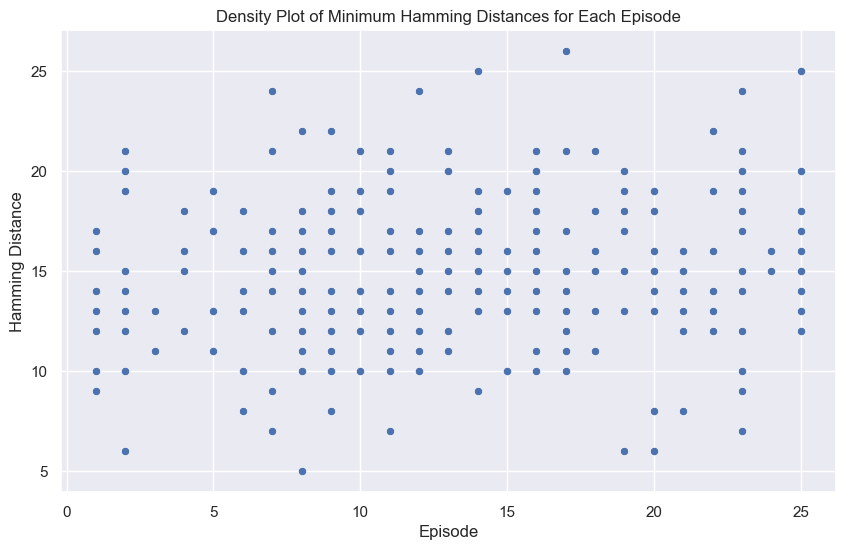

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Convert the min_hamming_distances dictionary to a DataFrame
df = pd.DataFrame(min_hamming_distances)

# Melt the DataFrame to a long format suitable for plotting
df_melted = df.melt(var_name='Episode', value_name='Hamming Distance')
# Convert the 'Episode' column to numeric
df_melted['Episode'] = pd.to_numeric(df_melted['Episode'])

# Create a density plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_melted, x='Episode', y='Hamming Distance')

# Set the title of the plot
plt.title('Density Plot of Minimum Hamming Distances for Each Episode')

# Show the plot
plt.show()

In [ ]:
# # compare the hashes with the preloaded hashes and find the most similar frames
# similar_frames = {}
# for idx, hash in tqdm(enumerate(hashes)):
#     for episode_number, episode_hashes in preloaded_hashes['1'].items():
#         for i, hash_val in enumerate(episode_hashes):
#             similar, distance = hashes_are_similar(hash, hash_val,threshold=8)
#             if similar:
#                 if episode_number not in similar_frames:
#                     similar_frames[episode_number] = {}
#                 if i not in similar_frames[episode_number]:
#                     similar_frames[episode_number][i] = []
#                 similar_frames[episode_number][i].append((idx, distance))

13183it [00:16, 816.88it/s]


In [ ]:
# similar_frames.keys()

dict_keys(['19', '9', '11', '2', '7', '23', '8', '20', '21', '6'])

In [ ]:
# for episode_number, frames in similar_frames.items():
#     print(episode_number,frames)

19 {3: [(64, 8), (66, 8), (68, 8), (70, 8), (71, 7), (72, 7), (73, 6), (74, 6), (75, 6), (76, 8), (77, 6)]}
9 {4: [(69, 8), (86, 8), (87, 8)]}
11 {1: [(86, 8), (87, 8), (92, 8), (97, 7), (99, 8), (3309, 8), (6939, 8), (6942, 8)]}
2 {12: [(150, 8), (151, 8), (152, 7), (153, 7), (154, 6), (155, 8), (156, 8), (157, 8), (489, 8), (6864, 8), (6931, 7), (6935, 8), (6937, 8), (6941, 8), (7204, 7), (7444, 7)]}
7 {9: [(2331, 8), (2333, 8), (2334, 8), (2335, 8), (2336, 8), (2338, 8), (2340, 8), (2341, 8), (2342, 7), (2343, 7), (2344, 8), (2345, 7), (2346, 7), (2347, 7), (2348, 8), (2350, 8), (2352, 8), (2353, 8), (2354, 8), (2355, 8), (2356, 8), (2357, 8), (2358, 8), (2359, 8), (2360, 8), (2361, 8), (2362, 8), (2363, 8), (2364, 8), (2365, 8), (2379, 8), (2380, 8), (2381, 8), (2384, 8), (2385, 8), (2386, 8), (2387, 8), (2388, 8), (2389, 8), (2390, 8), (2391, 8), (2392, 8), (2393, 8), (2394, 8), (2395, 8), (2396, 8), (2397, 8), (2398, 8), (2399, 8), (2400, 8), (2401, 8), (2402, 8), (2403, 8), (240

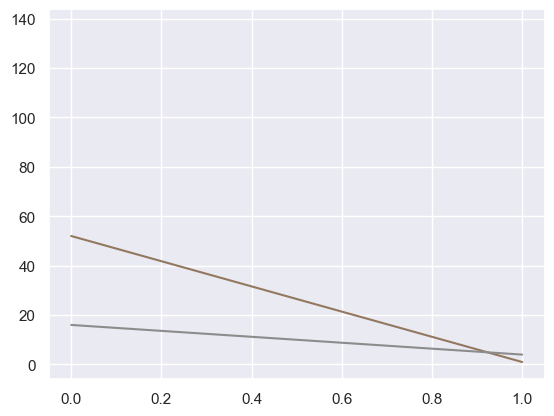

In [ ]:
# # plot how many frames were similar for each episode
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_theme()
# for episode_number, frames_dict in similar_frames.items():
#     plt.plot([len(frames) for frames in frames_dict.values()], label=f"Episode {episode_number}")


In [ ]:
# similar_frames['2']

{12: [(150, 8),
  (151, 8),
  (152, 7),
  (153, 7),
  (154, 6),
  (155, 8),
  (156, 8),
  (157, 8),
  (489, 8),
  (6864, 8),
  (6931, 7),
  (6935, 8),
  (6937, 8),
  (6941, 8),
  (7204, 7),
  (7444, 7)]}

In [ ]:
# # make a scatter plot with the epsiode number on the x axis and the distance on the y axis
# for episode_number, frames_dict in similar_frames.items():
#     for frame_number, distance in frames_dict.items():
#         print(episode_number, frame_number, distance)
#         break
#         #plt.scatter(episode_number, distance, label=f"Episode {episode_number}")
# # plt.xlabel("Episode Number")

19 3 [(64, 8), (66, 8), (68, 8), (70, 8), (71, 7), (72, 7), (73, 6), (74, 6), (75, 6), (76, 8), (77, 6)]
9 4 [(69, 8), (86, 8), (87, 8)]
11 1 [(86, 8), (87, 8), (92, 8), (97, 7), (99, 8), (3309, 8), (6939, 8), (6942, 8)]
2 12 [(150, 8), (151, 8), (152, 7), (153, 7), (154, 6), (155, 8), (156, 8), (157, 8), (489, 8), (6864, 8), (6931, 7), (6935, 8), (6937, 8), (6941, 8), (7204, 7), (7444, 7)]
7 9 [(2331, 8), (2333, 8), (2334, 8), (2335, 8), (2336, 8), (2338, 8), (2340, 8), (2341, 8), (2342, 7), (2343, 7), (2344, 8), (2345, 7), (2346, 7), (2347, 7), (2348, 8), (2350, 8), (2352, 8), (2353, 8), (2354, 8), (2355, 8), (2356, 8), (2357, 8), (2358, 8), (2359, 8), (2360, 8), (2361, 8), (2362, 8), (2363, 8), (2364, 8), (2365, 8), (2379, 8), (2380, 8), (2381, 8), (2384, 8), (2385, 8), (2386, 8), (2387, 8), (2388, 8), (2389, 8), (2390, 8), (2391, 8), (2392, 8), (2393, 8), (2394, 8), (2395, 8), (2396, 8), (2397, 8), (2398, 8), (2399, 8), (2400, 8), (2401, 8), (2402, 8), (2403, 8), (2404, 8), (2405, 

In [ ]:
# import cv2
# import numpy as np

# def average_hash(image, hash_size=8, mean=np.mean):
#     if hash_size < 2:
#         raise ValueError('Hash size must be greater than or equal to 2')

#     # Convert the image to grayscale and resize it
#     gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
#     resized_image = cv2.resize(gray_image, (hash_size, hash_size))

#     # Find the average pixel value
#     avg = mean(resized_image)

#     # Create string of bits
#     diff = resized_image > avg

#     # Make a hash
#     return ImageHash(diff)


In [ ]:
# # Open the .mkv file and extract frames for the first 5 minutes
# cap = cv.VideoCapture(mkv_file)
# frames = []
# hashes = []
# frame_count = 0
# # Initiate SIFT detector
# sift = cv.SIFT_create()
# for frame in tqdm(range(0,1000,10)):
#     success, frame = cap.read()
#     if not success:
#         break
#     hash = average_hash(frame)
# cap.release()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 110.95it/s]


In [ ]:
# hash

array([[False, False,  True,  True, False,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [False, False, False,  True,  True, False,  True, False],
       [False, False,  True, False,  True,  True,  True, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False]])

In [ ]:
str(hash)

'363e3e1a2e000000'